# Title I Allocations w/ DP ACS

In [3]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [4]:
%load_ext autoreload
%autoreload 2

from dp_policy.titlei.utils import get_sppe
import pandas as pd

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [5]:
from dp_policy.titlei.utils import get_saipe

saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                               cv  
State FIPS Code District ID        
1               190          0.23  
                5            0.23  
                30           0.28  
                60           0.35  
                90           0.23

In [6]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [12]:
weighting(1559, 10000)

1993.0

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


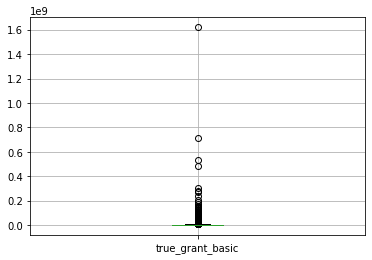

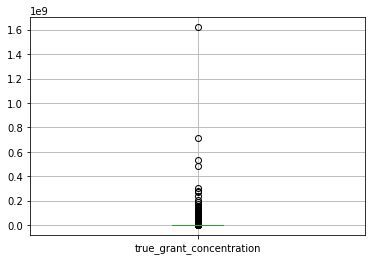

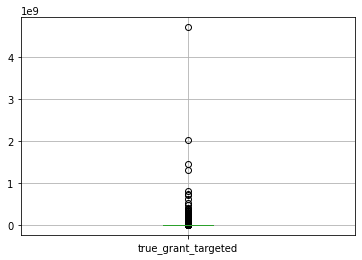

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [24]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(State FIPS Code  District ID
 1                190            3.466310e+04
                  5              2.204851e+04
                  30             1.691907e+04
                  60             8.846642e+03
                  90             2.204514e+04
                                     ...     
 56               6240           7.129927e+03
                  5820           6.520007e+02
                  4830           5.489508e+03
                  6090           1.435926e+03
 72               30             3.193688e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 State FIPS Code  District ID
 1                190              6709.803011
                  5                4098.321127
                  30               2585.856639
                  60               1466.951013
                  90               3067.759224
                                     ...      
 56               6240             1269.258241
                  5820               90

### Results
First, using the full Sonnenberg authorization algo.

In [26]:
grants = funding(SonnenbergAuthorizer, saipe, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"))
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reduced to 15999020221.60293 allocated.


,true_pop_total,true_children_total,true_children_poverty,cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,...,true_ci_upper,true_ci_lower,est_grant_basic_ci_upper,est_grant_basic_ci_lower,est_grant_concentration_ci_upper,est_grant_concentration_ci_lower,est_grant_targeted_ci_upper,est_grant_targeted_ci_lower,est_ci_upper,est_ci_lower
count,1.318200e+04,1.318200e+04,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,...,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,2.651938e+04,4.049290e+03,625.253224,0.383360,2.651938e+04,4.049291e+03,625.256346,625.253224,625.256346,13027.845092,...,1.213702e+06,1.213702e+06,1.213702e+06,1.213702e+06,1.213702e+06,1.213702e+06,1.213702e+06,1.213702e+06,1.581198e+07,5.569131e+06
std,1.155746e+05,1.728792e+04,3467.140325,0.171494,1.155746e+05,1.728792e+04,3467.140597,3467.140325,3467.140597,3667.794832,...,9.072442e+06,1.368358e+07,7.106615e+06,9.053746e+06,8.260585e+06,1.692069e+07,1.052004e+07,1.565711e+07,1.181959e+08,6.279018e+07
min,0.000000e+00,0.000000e+00,0.000000,0.150000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,...,0.000000e+00,-1.877257e+05,0.000000e+00,-2.891403e+05,0.000000e+00,-5.441109e+05,0.000000e+00,0.000000e+00,0.000000e+00,-8.628742e+05
25%,2.802000e+03,4.260000e+02,52.000000,0.230000,2.801732e+03,4.259967e+02,52.095602,52.000000,52.095602,10157.000000,...,1.129982e+05,0.000000e+00,1.474605e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.845538e+04,0.000000e+00,1.474764e+06,0.000000e+00
50%,7.911000e+03,1.186000e+03,147.000000,0.350000,7.910749e+03,1.185937e+03,147.175757,147.000000,147.175757,12159.000000,...,2.893157e+05,5.307207e+04,3.598144e+05,1.448226e+05,2.370775e+05,0.000000e+00,2.579910e+05,0.000000e+00,3.765837e+06,2.438032e+05
75%,2.101825e+04,3.222000e+03,411.000000,0.420000,2.101805e+04,3.221968e+03,411.297458,411.000000,411.297458,15780.000000,...,7.866296e+05,3.663781e+05,9.061392e+05,6.559345e+05,8.112468e+05,0.000000e+00,7.120474e+05,3.210211e+05,1.025504e+07,1.680841e+06
max,8.336817e+06,1.193045e+06,259012.000000,0.670000,8.336817e+06,1.193045e+06,259011.973719,259012.000000,259011.973719,22845.000000,...,7.932588e+08,1.214449e+09,6.018906e+08,7.663601e+08,6.998595e+08,1.442154e+09,9.376912e+08,1.426419e+09,1.033459e+10,5.572770e+09


In [46]:
import itertools
from dp_policy.titlei.allocators import Allocator

def test_params(saipe, mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0]):
    allocations = []
    print(f"{len(eps)*len(delta)} iters:")
    i = 0
    for d in delta:
        for e in eps:
            print(i, end=" ")
            i += 1
            allocations.append(funding(
                SonnenbergAuthorizer,
                saipe,  
                mech(saipe, e, d), 
                get_sppe("../data/sppe18.xlsx"), 
                verbose=False,
                uncertainty=False
            ).reset_index())
    return pd.concat(allocations, axis=0, join="inner", keys=itertools.product(delta, eps), names=["delta", "epsilon", "id"])

calc_total = SonnenbergAuthorizer.calc_total

def plot_results(results, delta=False):
    results = calc_total(results)
    
    eps, allocations = list(zip(*results.groupby("epsilon")))
    
    mse = []
    
    for e, alloc in results.groupby("epsilon"):
        for grant_type in ("basic", "concentration", "targeted", "total"):
            error = alloc[f"true_grant_{grant_type}"] - alloc[f"est_grant_{grant_type}"]
            error_prop = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])\
                - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
            if (e == 2.5) or (e > 0.1 and e < 0.11):
                print(f"## {grant_type} grants ##")
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"RMSE prop eps={e}:", sum(abs(error_prop)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))
        
            if grant_type == "total":
                mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
    
    grant_type = "total"
    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        ids = alloc.index.get_level_values("id").astype('str')
        plt.scatter(ids, alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(ids, alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

test_params(saipe, Laplace, eps=[0.1, 1.0], delta=[0.0]).head()

2 iters:
0 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
1 136021116192.56747 authorized reduced to 15999020221.60293 allocated.


State FIPS Code  District ID State Postal Code  \
delta epsilon id                                                   
0.0   0.1     0                 1          190                AL   
              1                 1            5                AL   
              2                 1           30                AL   
              3                 1           60                AL   
              4                 1           90                AL   

                                                 Name  true_pop_total  \
delta epsilon id                                                        
0.0   0.1     0        Alabaster City School District           34669   
              1      Albertville City School District           22051   
              2   Alexander City City School District           16920   
              3        Andalusia City School District            8842   
              4         Anniston City School District           22043   

                  true_children_total  true_children_poverty    cv  \
delta epsilon id                                                     
0.0   0.1     0                  6710                    649  0.23   
              1                  4131                    957  0.23   
              2                  2575                    703  0.28   
              3                  1465                    406  0.35   
              4                  3065                   1057  0.23   

                  est_pop_total  est_children_total  ...  \
delta epsilon id                                     ...   
0.0   0.1     0    34661.480759         6709.133148  ...   
              1    22048.271749         4140.314291  ...   
              2    16923.566600         2572.990046  ...   
              3     8848.283904         1457.579485  ...   
              4    22018.679435         3076.223373  ...   

                  est_children_eligible    sppe  true_grant_basic  \
delta epsilon id                                                    
0.0   0.1     0              663.221939  9697.0      1.085565e+06   
              1              949.322063  9697.0      1.600748e+06   
              2              709.032443  9697.0      1.175889e+06   
              3              421.506404  9697.0      6.791052e+05   
              4             1056.576713  9697.0      1.768015e+06   

                  true_grant_concentration  true_grant_targeted  \
delta epsilon id                                                  
0.0   0.1     0               0.000000e+00         6.487332e+05   
              1               2.169641e+06         1.220748e+06   
              2               1.593791e+06         1.025328e+06   
              3               9.204538e+05         5.972544e+05   
              4               2.396354e+06         1.868482e+06   

                  est_grant_basic  est_grant_concentration  \
delta epsilon id                                             
0.0   0.1     0      1.108703e+06             0.000000e+00   
              1      1.586974e+06             2.148357e+06   
              2      1.185284e+06             1.604571e+06   
              3      7.046289e+05             9.538871e+05   
              4      1.766271e+06             2.391079e+06   

                  est_grant_targeted  true_grant_total  est_grant_total  
delta epsilon id                                                         
0.0   0.1     0         6.618146e+05      6.364793e+05     6.495153e+05  
              1         1.196511e+06      1.537382e+06     1.516840e+06  
              2         1.040119e+06      1.192418e+06     1.204774e+06  
              3         6.364127e+05      6.911538e+05     7.250880e+05  
              4         1.857923e+06      1.953202e+06     1.946438e+06  

[5 rows x 22 columns]

In [30]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 5.0, 10.0, 20.0])
results.to_csv("../results/titlei_laplace.csv")

5 iters:
0 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
1 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
2 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
3 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
4 136021116192.56747 authorized reduced to 15999020221.60293 allocated.


### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [36]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [37]:
# RMSE
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

2912.5684564322705

In [38]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 26638180.87756897


In [41]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1557.1297884973883

In [42]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70606.82647769673

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [47]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(0.02, 1, endpoint=False, num=10))
)
results.to_csv("../results/titlei_gaussian.csv")

510 iters:
0 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
1 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
2 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
3 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
4 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
5 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
6 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
7 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
8 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
9 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
10 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
11 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
12 136021116192.56747 authorized reduced to 15999020221.60293 allocated.
13 136021116192.56747 authorized reduced to 159990

In [48]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'id'])

0.216


/Users/steed/dp-acs/dp_policy/titlei/allocators.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["est_grant_total"] = \
/Users/steed/dp-acs/dp_policy/titlei/allocators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return results


## basic grants ##
RMSE at eps=0.1098541141987558: 4953.4271241568695
RMSE prop eps=0.1098541141987558: 0.002122312163062364
Total misalloc at eps=0.1098541141987558: 33954915.21336697
Total true alloc: 15999020221.602888
## concentration grants ##
RMSE at eps=0.1098541141987558: 39277.555679401965
RMSE prop eps=0.1098541141987558: 0.0028441625983425464
Total misalloc at eps=0.1098541141987558: 45503814.9244583
Total true alloc: 15999020221.602951
## targeted grants ##
RMSE at eps=0.1098541141987558: 9486.464102303416
RMSE prop eps=0.1098541141987558: 0.0020396857693591145
Total misalloc at eps=0.1098541141987558: 32632973.869694978
Total true alloc: 15999020221.602936
## total grants ##
RMSE at eps=0.1098541141987558: 41652.27636737446
RMSE prop eps=0.1098541141987558: 0.0023271099813417795
Total misalloc at eps=0.1098541141987558: 111694438.94816954
Total true alloc: 47997060664.80879
## basic grants ##
RMSE at eps=2.5: 3234.2428799605013
RMSE prop eps=2.5: 0.000770537123684657
Total

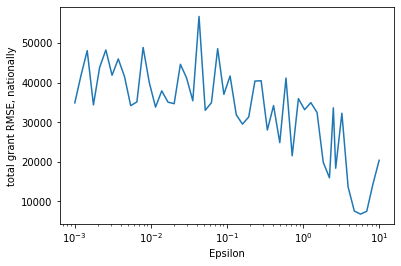

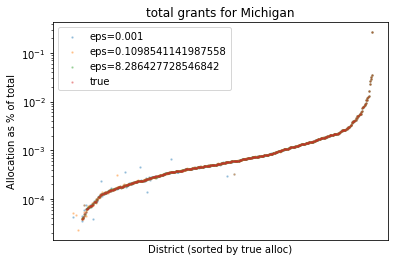

<ipython-input-46-0d755cf381cb>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


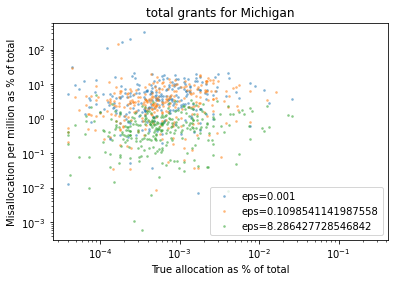

In [49]:
print(results.index.get_level_values('delta').unique()[2])
plot_results(results.xs(results.index.get_level_values('delta').unique()[2], level='delta'))

## basic grants ##
RMSE at eps=0.1098541141987558: 2694.021156058769
RMSE prop eps=0.1098541141987558: 0.0005744917289693
Total misalloc at eps=0.1098541141987558: 9191304.788918719
Total true alloc: 15999020221.602888
## concentration grants ##
RMSE at eps=0.1098541141987558: 30413.056062151958
RMSE prop eps=0.1098541141987558: 0.001035801611448218
Total misalloc at eps=0.1098541141987558: 16571810.927151449
Total true alloc: 15999020221.602951
## targeted grants ##
RMSE at eps=0.1098541141987558: 2783.0982858553443
RMSE prop eps=0.1098541141987558: 0.0005081627848486202
Total misalloc at eps=0.1098541141987558: 8130106.670651772
Total true alloc: 15999020221.602936
## total grants ##
RMSE at eps=0.1098541141987558: 30913.825522253726
RMSE prop eps=0.1098541141987558: 0.000700057093690702
Total misalloc at eps=0.1098541141987558: 33600682.7948952
Total true alloc: 47997060664.80879
## basic grants ##
RMSE at eps=2.5: 2625.3297052786256
RMSE prop eps=2.5: 0.0004395581842232353
Total mi

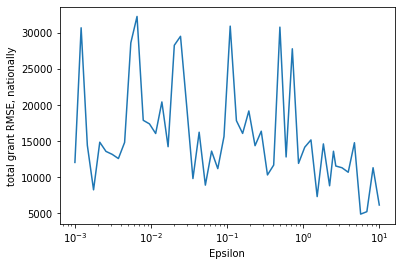

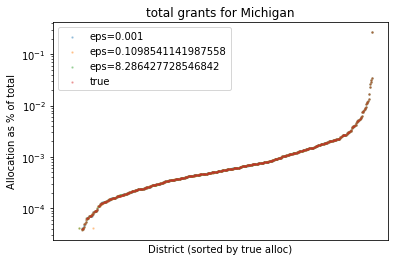

<ipython-input-46-0d755cf381cb>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


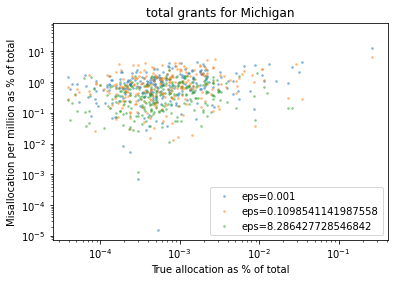

In [50]:
plot_results(results.xs(0.804))

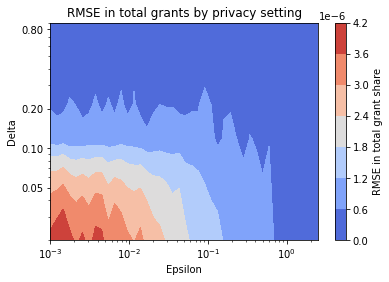

In [51]:
from matplotlib.ticker import FormatStrFormatter

results = calc_total(results)
eps = list(results.index.get_level_values("epsilon").unique())

delts = list(results.index.get_level_values("delta").unique())
mse = np.zeros((len(eps), len(delts)))
for params, alloc in results.groupby(["epsilon", "delta"]):
    
    e, d = params
    error = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]) \
        - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
    mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
    
plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([0.05, 0.1, 0.2, 0.8])
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.xlim(None, 2.5)
plt.xlabel("Epsilon")
plt.ylabel("Delta")
plt.title("RMSE in total grants by privacy setting")
plt.colorbar(label="RMSE in total grant share")
plt.show()

# Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

In [130]:
from dp_policy.titlei.utils import get_allocation_data

true_allocations = get_allocation_data("../data/titlei-allocations_20")
print(true_allocations.columns)
true_allocations["Allocation_2020"].sum()

Index(['LEAID', 'District', 'Allocation_2020', 'state'], dtype='object')


15999020221.602928

In [140]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import SonnenbergAuthorizer

allocations = funding(
    SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx")
)
allocs = allocations[
    ["true_grant_total", "true_grant_basic", "true_grant_concentration", "true_grant_targeted", "true_children_total", "true_children_eligible"]
].join(true_allocations[["Allocation_2020", "District"]])
allocs["error"] = allocs.Allocation_2020 - allocs.true_grant_total
allocs.true_grant_total.sum()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reduced to 15999020221.60293 allocated.


15999046700.71252

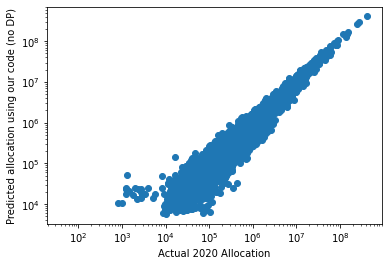

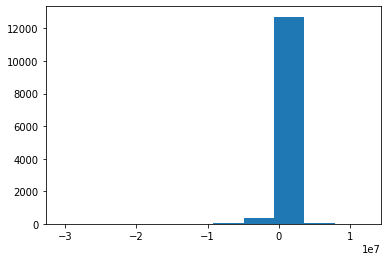

In [136]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.scatter(allocs.Allocation_2020, allocs.true_grant_total)
plt.xlabel("Actual 2020 Allocation")
plt.ylabel("Predicted allocation using our code (no DP)")
plt.show()
plt.hist(allocs.error)
plt.show()

Our method seems to be a little heteroskedastic. Variation could be due to 1) approximations in our funding algo; 2) differences in data.

In [137]:
# error per student
allocs["error_per_capita"] = allocs.error / allocs.true_children_total
np.mean(allocs.error_per_capita), np.sqrt(np.mean(allocs.error_per_capita**2))

(20.879231455964167, 148.36257841383988)

In [138]:
allocs.sort_values("error_per_capita").head(10)

,,true_grant_total,true_grant_basic,true_grant_concentration,true_grant_targeted,true_children_total,true_children_eligible,Allocation_2020,District,error,error_per_capita
State FIPS Code,District ID,,,,,,,,,,
30,9210,5.259479e+04,46843.071951,6.349072e+04,5.122794e+04,55,25,1308.576975,Drummond High School District,-51286.211907,-932.476580
35,330,2.510612e+05,182321.355553,2.471169e+05,2.938792e+05,166,109,119891.947939,Carrizozo Municipal Schools,-131169.239279,-790.176140
41,3630,8.201031e+04,68626.885861,9.301633e+04,8.515564e+04,74,36,24329.785959,Harney County Union High School District 1J,-57680.528122,-779.466596
35,1,1.175623e+05,93669.687257,1.269591e+05,1.276975e+05,109,56,37999.407212,Vaughn Municipal Schools,-79562.935826,-729.935191
6,19920,4.708628e+04,38146.911424,5.170402e+04,5.039245e+04,31,19,25151.928704,Klamath River Union Elementary School District,-21934.346974,-707.559580
30,13140,2.705267e+04,28105.843171,3.809443e+04,2.155492e+04,39,15,0.000000,Greycliff Elementary School District,-27052.672088,-693.658259
6,37470,3.366669e+05,273051.576512,3.700919e+05,3.599461e+05,295,136,142635.600476,South Fork Union School District,-194031.270623,-657.733121
13,5100,1.278281e+06,996370.877624,1.350473e+06,1.414921e+06,1167,578,533694.657463,Treutlen County School District,-744586.668896,-638.034849
30,19740,2.142242e+04,22484.674536,3.047555e+04,1.679604e+04,34,12,0.000000,Opheim K-12 Schools,-21422.420537,-630.071192


# Uncertainty

## Calculating confidence intervals

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


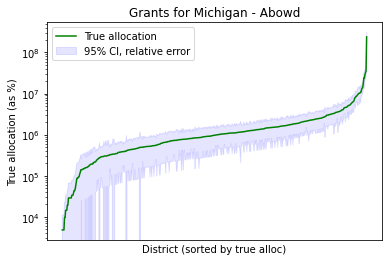

In [86]:
from dp_policy.api import titlei_data as data

# test with one run of abowd
allocator = AbowdAllocator(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()
estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values("true_grant_total")
y = estimates.true_grant_total
x = estimates.index.get_level_values("District ID").astype('str')
ax = plt.gca()

plt.plot(x, y, color='green', label="True allocation")
ax.fill_between(x, estimates.true_ci_lower, estimates.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan - Abowd")
ax.legend()
plt.show()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


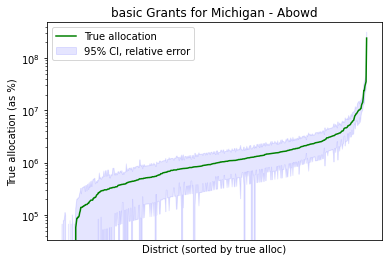

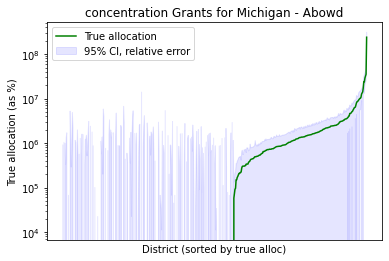

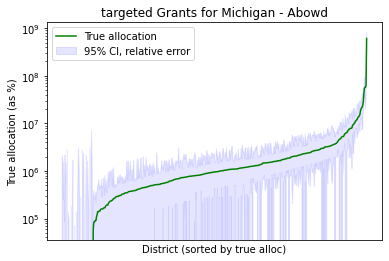

In [99]:
# test with one run of Sonnenberg
allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

for grant_type in ["basic", "concentration", "targeted"]:
    estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values(f"true_grant_{grant_type}")
    y = estimates[f"true_grant_{grant_type}"]
    x = estimates.index.get_level_values("District ID").astype('str')
    ax = plt.gca()

    plt.plot(x, y, color='green', label="True allocation")
    ax.fill_between(x, estimates[f"true_grant_{grant_type}_ci_upper"], estimates[f"true_grant_{grant_type}_ci_lower"], color='b', alpha=0.1, label="95% CI, relative error")
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"{grant_type} Grants for Michigan - Abowd")
    ax.legend()
    plt.show()

## Measures of "cheating" - districts receiving less than they should, if data were perfect

One method (see notes) is to compute the expected value of $y$ (the expected allocation) given the following assumptions:
1. $\mu$ is normally distributed
2. $\hat{\mu}$ is unbiased
3. $\hat{\nu}$ is unbiased and a point mass

See notes for the expectation math.

An example for basic grants:

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


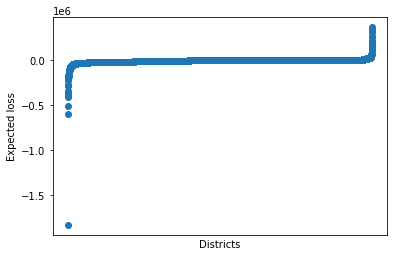

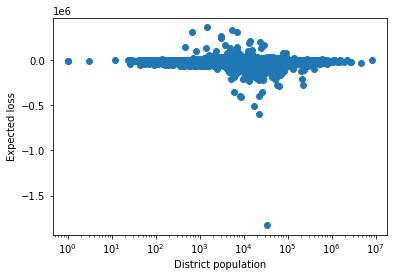

28603.53762995876

In [72]:
from dp_policy.api import titlei_data as data

allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()

df = allocator.estimates
mu_hat = df.true_children_eligible
nu_hat = df.true_children_total
k, _ = allocator.adj_sppe()
sigma_mu = df.cv * mu_hat

expected_y = k*mu_hat*np.where(
    nu_hat <= 500,
    1 - stats.norm.cdf((10-mu_hat)/sigma_mu),
    stats.norm.cdf((mu_hat - 0.02*nu_hat)/sigma_mu)
)
y_hat = allocator.estimates.true_grant_basic
df["expected_loss"] = expected_y - y_hat
df = df.sort_values("expected_loss")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
# ax.set_yscale('log')
plt.scatter(range(len(expected_y)), df["expected_loss"])
plt.xlabel("Districts")
plt.ylabel("Expected loss")
plt.show()

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.scatter(allocator.estimates.true_pop_total, df["expected_loss"])
ax.set_xscale('log')
plt.xlabel("District population")
plt.ylabel("Expected loss")
plt.show()

# RMSE
np.sqrt(np.mean((expected_y - y_hat)**2))

In [79]:
df.tail()

,,State Postal Code,Name,true_pop_total,true_children_total,true_children_poverty,cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,...,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted,true_grant_total,est_grant_total,expected_loss
State FIPS Code,District ID,,,,,,,,,,,,,,,,,,,,,
6,22650,CA,Los Altos Elementary School District,43982,5603,111,0.23,43982.888439,5603.038256,111.017185,111,...,12510.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,268524.270545
36,23220,NY,Plainview-Old Bethpage Central School District,29157,4960,99,0.23,29156.673101,4959.831021,98.949288,99,...,22845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,307372.295144
25,12660,MA,Westford School District,23543,5318,105,0.23,23542.451080,5317.930475,104.684282,105,...,16973.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,313558.031112
36,18630,NY,Massapequa Union Free School District,47720,8357,153,0.23,47718.799525,8356.764804,153.574786,153,...,22845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329039.816616
25,8370,MA,Needham School District,30520,6005,119,0.23,30519.932509,6005.191517,119.185830,119,...,16973.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360147.140308


## Results

In [40]:
from dp_policy.titlei.mechanisms import Gaussian, Laplace
from dp_policy.api import titlei_funding

# 100 trials of DP
trials_laplace = []
trials_gaussian = []
for i in range(100):
    trials_laplace.append(funding(SonnenbergAuthorizer, saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx")))
    trials_gaussian.append(funding(SonnenbergAuthorizer, saipe, Gaussian(saipe, 2.52, 0.8), get_sppe("../data/sppe18.xlsx")))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136029745217.41924 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136023207805.14896 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136030412637.54117 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136027512384.92245 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136035719395.60849 authorized reducedto 

In [110]:
import pickle

pickle.dump(trials_gaussian, open('../results/uncertainty_gaussian_sonnenberg.pkl', 'wb'))
pickle.dump(trials_laplace, open('../results/uncertainty_laplace_sonnenberg.pkl', 'wb'))

In [15]:
import pickle

trials_gaussian = pickle.load( open('../results/uncertainty_gaussian_sonnenberg.pkl', 'rb'))
trials_laplace = pickle.load( open('../results/uncertainty_laplace_sonnenberg.pkl', 'rb'))

[462828162.2201426, 462823382.15738565, 462835204.65707684, 462888258.3756584, 462909487.1781151, 462806519.4656864, 462759978.69908434, 462809326.3537339, 462832646.4212699, 462801445.2535471, 463014333.2966899, 462806183.4312506, 462843137.3364271, 462889384.6680894, 462812634.71223766, 462872584.8882659, 462901648.61562014, 462835927.1239207, 462855130.44010603, 462965511.28165185, 462753071.92643046, 462763572.9152061, 462767359.21800363, 462897804.53377336, 462850754.21426845, 462787991.701426, 462746278.9759413, 462804669.4949643, 462912098.1363503, 462830341.4196892, 462897199.7054589, 462927782.29642797, 462833599.03081065, 462896725.1327099, 462712977.11800754, 462817229.0892671, 462808051.8551805, 462798511.3482866, 462886648.01087546, 462822457.8504037, 462875088.0922983, 462791281.1642824, 462862831.1830925, 462835264.1957778, 462852695.123733, 462820136.730264, 462845697.21737427, 462823264.711906, 462851238.2425776, 462796610.5999292, 462873878.6993247, 462856652.580941, 

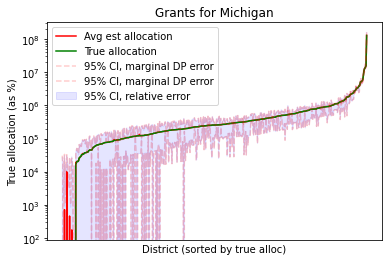

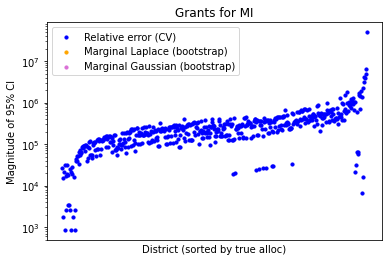

In [41]:
import scipy.stats as stats

def plot_uncertainty(grants, grants_other=None, state="MI", alpha=0.05):
    z = stats.norm.ppf(1-alpha/2)
    
    grants = [
        sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
        for sample in grants
    ]
    baseline = grants[0]
    x = baseline.index.get_level_values("District ID").astype('str')
    y = baseline.true_grant_total
    ax = plt.gca()
    
    print(list(grant.est_grant_total.sum() for grant in grants))
    
    # CI from relative error - 95% of samples differ by at most this much
    ax.fill_between(x, baseline.true_ci_lower, baseline.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
    
    # percentile interval from DP (bootstrapping) - 95% of samples differed by at most this much
    samples_mean = [
        sample.est_grant_total
        for sample in grants
    ]
    samples_upper = [
        sample.est_ci_upper
        for sample in grants
    ]
    samples_lower = [
        sample.est_ci_lower
        for sample in grants
    ]
    # get value for which 95% of samples are above (for lower) or below (for upper)
    mean = np.mean(samples_mean, axis=0)
    ci_lower = np.percentile(samples_lower, alpha/2, axis=0)
    ci_upper = np.percentile(samples_upper, 1-alpha/2, axis=0)

    plt.plot(x, mean, color='r', label="Avg est allocation")
    plt.plot(x, y, color='green', label="True allocation")
    plt.plot(x, ci_lower, 'r--', alpha=0.2, label="95% CI, marginal DP error")
#     ax.fill_between(x, baseline.true_ci_lower, ci_lower, color='r', alpha=0.1, label="95% CI, marginal DP error")
    plt.plot(x, ci_upper, 'r--', alpha=0.2, label="95% CI, marginal DP error")
#     ax.fill_between(x, baseline.true_ci_upper, ci_upper, color='r', alpha=0.1, label="95% CI, marginal DP error")
    

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for Michigan")
    ax.legend()
    plt.show()
    
    # plot of interval magnitude
    ax = plt.gca()
    ci = np.abs(baseline.true_ci_upper - baseline.true_ci_lower)
    plt.scatter(x, ci, s=10, color='b', label="Relative error (CV)")
    
    samples = [
        np.abs(sample.est_ci_upper - sample.est_ci_lower)
        for sample in grants
    ]
    plt.scatter(x, np.percentile(samples, 1-alpha/2, axis=0) - ci, s=10, color='orange', label="Marginal Laplace (bootstrap)")
    
    if grants_other is not None:
        grants_other = [
            sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
            for sample in grants_other
        ]
        samples_other = [
            np.abs(sample.est_ci_upper - sample.est_ci_lower)
            for sample in grants_other
        ]
        plt.scatter(
            x, 
            np.percentile(samples_other, 1-alpha/2, axis=0) - ci,
            s=10, color='orchid', label="Marginal Gaussian (bootstrap)"
        )


    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Magnitude of 95% CI")
    plt.title(f"Grants for {state}")
    ax.legend()
    plt.show()

plot_uncertainty(trials_laplace, trials_gaussian)

# Discrimination
## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [121]:
from dp_policy.titlei.utils import get_acs_data

demographics = get_acs_data(
    "../data/discrimination/CDP05.txt",
    "demo"
)
print(demographics.shape)
social = get_acs_data(
    "../data/discrimination/CDP02.txt",
    "social"
)
print(social.shape)
economic = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "social"
)
print(economic.shape)
housing = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "housing"
)
print(housing.shape)

(11721, 256)
(11720, 340)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 202)
(11721, 202)


In [122]:
acs = demographics.join(social, lsuffix="demo", rsuffix="social", how="inner")\
    .join(economic, rsuffix="econ", how="inner")\
    .join(housing, rsuffix="housing", how="inner")
print(acs.shape)

(11720, 1000)


In [123]:
saipe = get_saipe("../data/saipe19.xls")
saipe = saipe.join(acs, how="inner")

In [127]:
from dp_policy.titlei.mechanisms import Gaussian

results = test_params(
    saipe,
    Gaussian, 
    eps=[0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 15.0],
    delta=[0.1]
)

9 iters:
0 1 2 3 4 5 6 

KeyboardInterrupt: 

In [ ]:
grants = calc_total(results)
# for regression
grants["error"] = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
grants.to_csv("../results/discrimination.csv")

### Plot for just (0.1, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 0.1, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


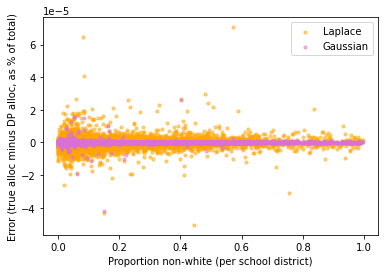

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()